### steps
1. - read and understand the data
2. - clean the data
3. - data prepration
4. - modelling
5. - Evaluation
6. - Visualization

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

from sklearn.metrics import davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

## Read and understand the data

In [180]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [181]:
data = pd.merge(transactions, customers, how='left', on='CustomerID')

In [182]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [183]:
data.shape

(1000, 10)

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
 7   CustomerName     1000 non-null   object 
 8   Region           1000 non-null   object 
 9   SignupDate       1000 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 78.3+ KB


## Clean the data

In [185]:
data.isnull().sum()

,0
TransactionID,0
CustomerID,0
ProductID,0
TransactionDate,0
Quantity,0
TotalValue,0
Price,0
CustomerName,0
Region,0
SignupDate,0


### there are no null values in the data

In [186]:
data.columns

Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price', 'CustomerName', 'Region',
       'SignupDate'],
      dtype='object')

In [187]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

In [188]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
 7   CustomerName     1000 non-null   object        
 8   Region           1000 non-null   object        
 9   SignupDate       1000 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 78.3+ KB


## Data preparation
- R(recency) : no. of days since last transaction
- F(frquency) : no. of transactions
- M(monetary) : total amount of transactions (revenue contributed)

In [189]:
#monatary -- amount
data['amount'] = data['Quantity'] * data['Price']

In [190]:
dfc = data.groupby(by = 'CustomerID')['amount'].sum().reset_index()

In [191]:
#frequency
dfc['frequency'] = data.groupby(by = 'CustomerID')['TransactionID'].count().reset_index()['TransactionID']

In [192]:
dfc.head()

,CustomerID,amount,frequency
0,C0001,3354.52,5
1,C0002,1862.74,4
2,C0003,2725.38,4
3,C0004,5354.88,8
4,C0005,2034.24,3


In [193]:
# recency
max_date = data['TransactionDate'].max()

In [194]:
data['diff'] = max_date - data['TransactionDate']

In [195]:
dfc['recency'] = data.groupby(by = 'CustomerID')['diff'].min().reset_index()['diff']

In [196]:
dfc.head()

,CustomerID,amount,frequency,recency
0,C0001,3354.52,5,55 days 17:55:44
1,C0002,1862.74,4,25 days 09:18:19
2,C0003,2725.38,4,125 days 16:05:56
3,C0004,5354.88,8,4 days 20:46:08
4,C0005,2034.24,3,54 days 10:29:38


In [197]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   CustomerID  199 non-null    object         
 1   amount      199 non-null    float64        
 2   frequency   199 non-null    int64          
 3   recency     199 non-null    timedelta64[ns]
dtypes: float64(1), int64(1), object(1), timedelta64[ns](1)
memory usage: 6.3+ KB


In [198]:
dfc['recency'] = dfc['recency'].dt.days

In [199]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  199 non-null    object 
 1   amount      199 non-null    float64
 2   frequency   199 non-null    int64  
 3   recency     199 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.3+ KB


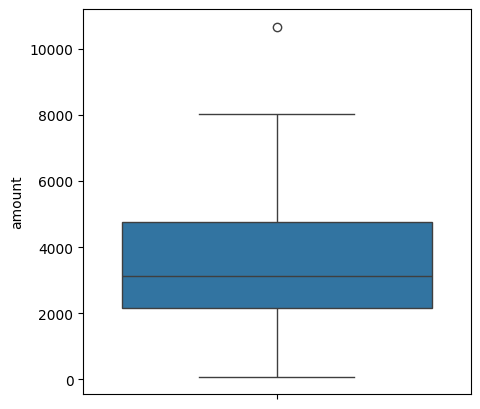

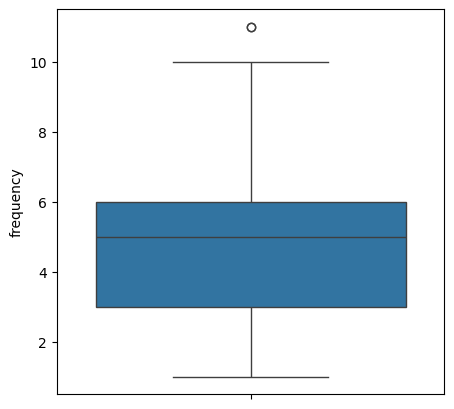

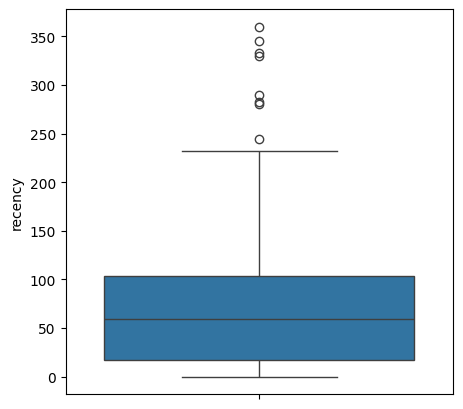

In [200]:
#outlier detection
for col in dfc.columns[1:]:
    plt.figure(figsize = (5,5))
    sns.boxplot(dfc[col])
    plt.show()

In [201]:
# removing statistical outliers
#amount
Q1 = dfc.amount.quantile(0.25)
Q3 = dfc.amount.quantile(0.75)
IQR = Q3 - Q1
group_df = dfc[(dfc.amount>=Q1-1.5*IQR) & (dfc.amount<=Q3+1.5*IQR)]

#frequency
Q1 = dfc.frequency.quantile(0.25)
Q3 = dfc.frequency.quantile(0.75)
IQR = Q3 - Q1
group_df = dfc[(dfc.frequency>=Q1-1.5*IQR) & (dfc.frequency<=Q3+1.5*IQR)]

#recency
Q1 = dfc.recency.quantile(0.25)
Q3 = dfc.recency.quantile(0.75)
IQR = Q3 - Q1
group_df = dfc[(dfc.recency>=Q1-1.5*IQR) & (dfc.recency<=Q3+1.5*IQR)]

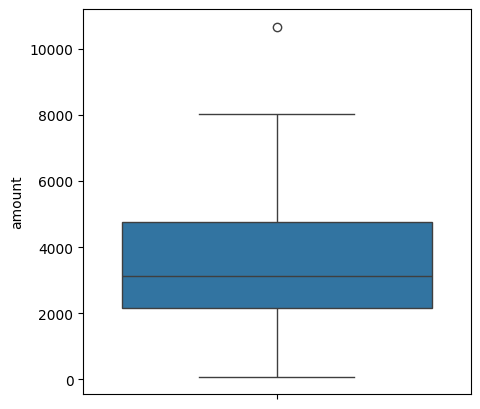

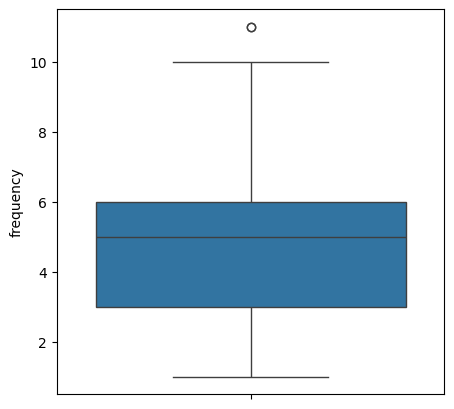

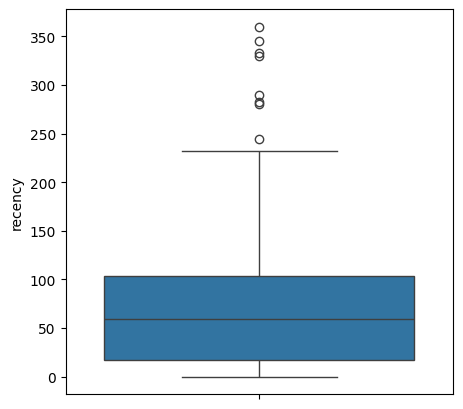

In [202]:
for col in dfc.columns[1:]:
    plt.figure(figsize = (5,5))
    sns.boxplot(dfc[col])
    plt.show()

In [203]:
#scalling
dfc_scaled = dfc.iloc[:,1:]
sc = StandardScaler()
dfc_scaled.iloc[:,1:] = sc.fit_transform(dfc_scaled.iloc[:,1:])
dfc_scaled.head()

,amount,frequency,recency
0,3354.52,-0.011458,-0.266933
1,1862.74,-0.467494,-0.690872
2,2725.38,-0.467494,0.722260
3,5354.88,1.356650,-0.987630
4,2034.24,-0.923530,-0.281064


### testing for the valid clusters in the data

In [204]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n)
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [205]:
hopkins(dfc_scaled)

0.9616457097822616

## Modeling

#### optimal number of clusters

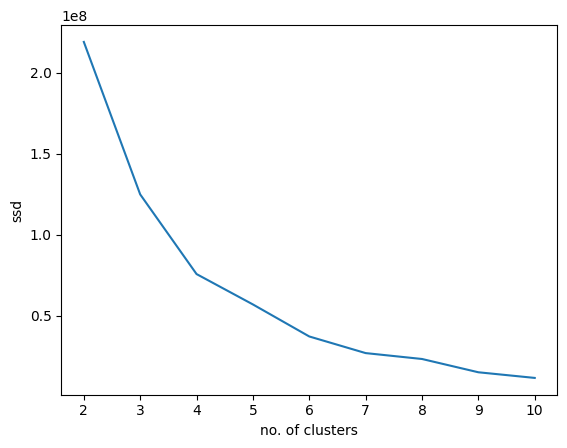

In [218]:
# elbow curve
ssd = []
range_of_clusters = range(2,11)
for cluster in range_of_clusters:
  kmeans = KMeans(n_clusters=cluster)
  kmeans.fit(dfc_scaled)
  ssd.append(kmeans.inertia_)
plt.plot(ssd)

positions = [0,1, 2, 3, 4, 5,6,7,8]
labels = range_of_clusters
plt.xticks(positions, labels)

plt.xlabel('no. of clusters')
plt.ylabel('ssd')
plt.show()

In [207]:
#silhouette
for n in range(2,9):
  cluster = KMeans(n_clusters=n)
  cluster.fit(dfc_scaled)
  labels = cluster.labels_
  print(n, silhouette_score(dfc_scaled, labels))

2 0.5948650084797624
3 0.5387775794830971
4 0.5362848561522604
5 0.5302643250768352
6 0.5343352919877704
7 0.5470694176111413
8 0.515093083925179


In [208]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(dfc_scaled)

KMeans(n_clusters=2)

In [209]:
dfc['cluster'] = kmeans.labels_

In [210]:
dfc.head()

,CustomerID,amount,frequency,recency,cluster
0,C0001,3354.52,5,55,1
1,C0002,1862.74,4,25,1
2,C0003,2725.38,4,125,1
3,C0004,5354.88,8,4,0
4,C0005,2034.24,3,54,1


In [211]:
db_index = davies_bouldin_score(dfc_scaled, dfc["cluster"])
db_index

0.5503940144368137

<Axes: xlabel='cluster', ylabel='amount'>

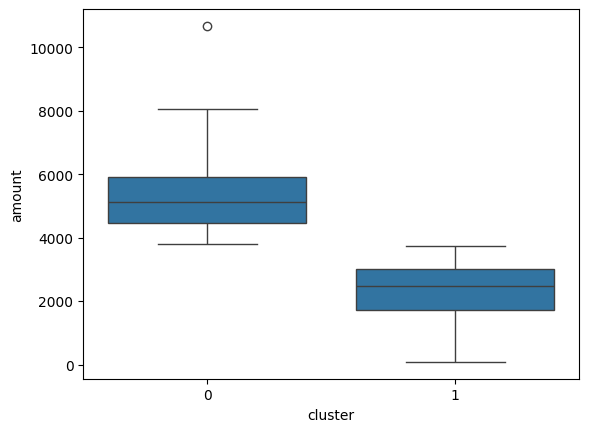

In [212]:
sns.boxplot(data = dfc, x = 'cluster', y = 'amount')

<Axes: xlabel='cluster', ylabel='frequency'>

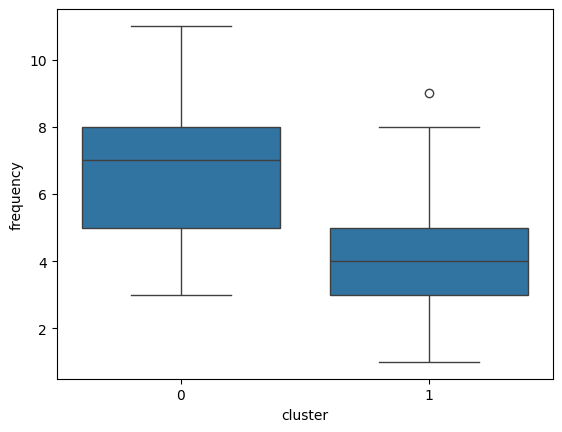

In [213]:
sns.boxplot(data = dfc, x = 'cluster', y = 'frequency')

<Axes: xlabel='cluster', ylabel='recency'>

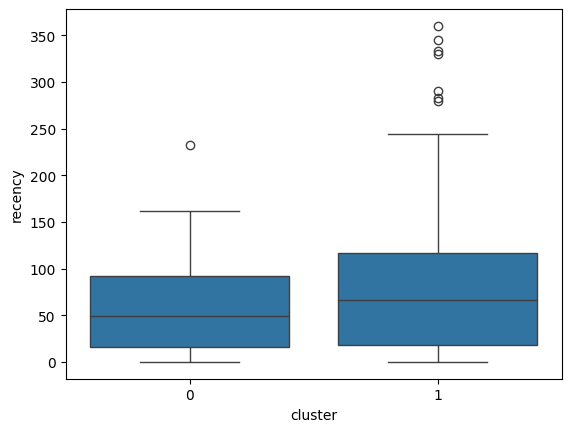

In [214]:
sns.boxplot(data = dfc, x = 'cluster', y = 'recency')

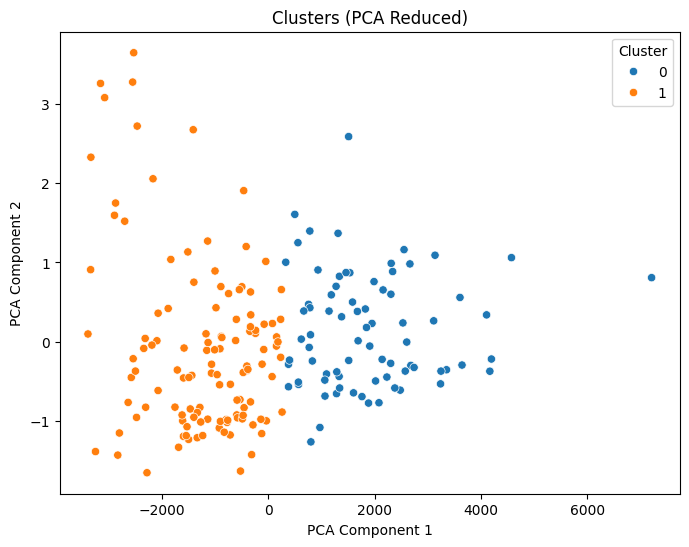

In [217]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(dfc_scaled)
dfc["PCA1"] = pca_features[:, 0]
dfc["PCA2"] = pca_features[:, 1]

# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=dfc, x="PCA1", y="PCA2", hue="cluster", palette="tab10")
plt.title("Clusters (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()